In [ ]:
import numpy as np
from numpy.typing import NDArray
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
from typing import Tuple
import time
import pandas as pd

In [3]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


def create_date(M, N):
    alpha = alpha_star(M)
    beta = beta_star(M, M)

    price_list = []
    quantity_list = []

    for _ in range(N):
        price = create_price(0.6, 1.0, M)
        quantity = quantity_function(price, alpha, beta)
        price_list.append(price)
        quantity_list.append(quantity)

    X = np.array(price_list)
    Y = np.array(quantity_list)

    return alpha, beta, X, Y


def create_bounds(M):
    lb = np.full(M, 0.6)
    ub = np.full(M, 1.0)

    bounds = []
    for i in range(M):
        bounds.append(lb[i])

    for i in range(M):
        bounds.append(ub[i])

    return lb, ub, bounds


In [4]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


In [5]:
def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
) -> Tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [6]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


In [7]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], bounds: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="L-BFGS-B",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [11]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    bounds: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


In [12]:
# CVを行う関数
def cross_validation_lb(
    lb: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(lb[m], 1.0) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


In [13]:
def esitimate_lb_nelder(lb, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_lb,
        lb,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((bounds_nelder.x[i], 1.0))
    return -bounds_nelder.fun, bounds_list


In [14]:
# CVを行う関数
def cross_validation_ub(
    ub: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds = [(0.6, ub[m]) for m in range(M)]

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


In [15]:
def esitimate_ub_nelder(ub, M, X, y, K, adaptive=True):
    # adaptive=Trueの場合、optionsにadaptive=Trueを指定
    bounds_nelder = minimize(
        cross_validation_ub,
        ub,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(M)],
        options={"adaptive": adaptive},
    )

    bounds_list = []
    for i in range(M):
        bounds_list.append((0.6, bounds_nelder.x[i]))
    return -bounds_nelder.fun, bounds_list


In [16]:
# CVを行う関数
def cross_validation_bounds_inf(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return np.inf

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


In [23]:
def estimate_bounds_inf_nelder(bounds, M, X, y, K, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_inf,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds


In [24]:
# CVを行う関数
def cross_validation_bounds_zero(
    bounds: list[float],
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    bounds_list = []

    for i in range(M):
        if bounds[i] > bounds[i + M]:
            return 0

        else:
            bounds_list.append((bounds[i], bounds[i + M]))

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）

        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds_list,
            method="L-BFGS-B",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return -np.mean(optimal_sales_list)


In [25]:
def estimate_bounds_zero_nelder(bounds, M, X, y, K, adaptive=True):
    bounds_nelder = minimize(
        cross_validation_bounds_zero,
        bounds,
        args=(X, y, M, K),
        method="Nelder-Mead",
        bounds=[(0.6, 1.0) for _ in range(2 * M)],
        options={"adaptive": adaptive},
    )

    opt_bounds = []
    for i in range(M):
        opt_bounds.append((bounds_nelder.x[i], bounds_nelder.x[i + M]))

    return -bounds_nelder.fun, opt_bounds


In [46]:
K = 5
M = 5
N = 500


In [52]:
# データを生成
alpha, beta, X, y = create_date(M, N)
lb, ub, bounds = create_bounds(M)


In [ ]:
so_salse_list = []
po_salse_list = []
t_salse_list = []
cv_list = []
lb_bo_list = []
ub_bo_list = []
inf_bo_list = []
zero_bo_list = []
lb_po_list = []
ub_po_list = []
inf_po_list = []
zero_po_list = []
t_lb_salse_list = []
t_ub_salse_list = []
t_inf_salse_list = []
t_zero_salse_list = []
inf_time_list = []
zero_time_list = []

for i in range(100):
    # データを生成
    alpha, beta, X, y = create_date(M, N)
    lb, ub, bounds = create_bounds(M)

    # salse_optimizeを行う
    optimal_sales, optimal_prices = sales_optimize(M, alpha, beta)
    so_salse_list.append(optimal_sales / optimal_sales)

    # predict_optimizeを行う
    optimal_sales, optimal_prices = predict_optimize(M, X, y, [(0.6, 1.0) for _ in range(M)])
    po_salse_list.append(optimal_sales / optimal_sales)

    # true_salesを計算
    true_sales = sum(sales_function(optimal_prices, alpha, beta))
    t_salse_list.append(true_sales / optimal_sales)

    # cross_validationを行う
    cv_sales = cross_validation(X, y, M, K, [(0.6, 1.0) for _ in range(M)])
    cv_list.append(cv_sales / optimal_sales)

    # estimate_lb_nelderを行う
    lb_sales, lb_bounds = esitimate_lb_nelder(lb, M, X, y, K, False)
    lb_bo_list.append(lb_sales / optimal_sales)

    lb_po_salse, lb_po_price = predict_optimize(M, X, y, lb_bounds)
    lb_po_list.append(lb_po_salse / optimal_sales)

    t_lb_salse_list.append(sum(sales_function(lb_po_price, alpha, beta)) / optimal_sales)

    # estimate_ub_nelderを行う
    ub_sales, ub_bounds = esitimate_ub_nelder(ub, M, X, y, K, False)
    ub_bo_list.append(ub_sales / optimal_sales)

    ub_po_salse, ub_po_price = predict_optimize(M, X, y, ub_bounds)
    ub_po_list.append(ub_po_salse / optimal_sales)

    t_ub_salse_list.append(sum(sales_function(ub_po_price, alpha, beta)) / optimal_sales)

    # estimate_bounds_inf_nelderを行う
    start_inf  = time.time()
    inf_sales, inf_bounds = estimate_bounds_inf_nelder(bounds, M, X, y, K, False)
    inf_bo_list.append(inf_sales / optimal_sales)
    inf_time_list.append(time.time()-start_inf)

    inf_po_salse, inf_po_price = predict_optimize(M, X, y, inf_bounds)
    inf_po_list.append(inf_po_salse / optimal_sales)

    t_inf_salse_list.append(sum(sales_function(inf_po_price, alpha, beta)) / optimal_sales)

    # estimate_bounds_zero_nelderを行う
    start_zero = time.time()
    zero_sales, zero_bounds = estimate_bounds_zero_nelder(bounds, M, X, y, K, False)
    zero_bo_list.append(zero_sales / optimal_sales)
    zero_time_list.append(time.time()-start_zero)

    zero_po_salse, zero_po_price = predict_optimize(M, X, y, zero_bounds)
    zero_po_list.append(zero_po_salse / optimal_sales)

    t_zero_salse_list.append(sum(sales_function(zero_po_price, alpha, beta)) / optimal_sales)


In [60]:
# それぞれのlistの平均を計算
so_salse = np.mean(so_salse_list)
po_salse = np.mean(po_salse_list)
t_salse = np.mean(t_salse_list)
cv = np.mean(cv_list)
lb_bo = np.mean(lb_bo_list)
ub_bo = np.mean(ub_bo_list)
inf_bo = np.mean(inf_bo_list)
zero_bo = np.mean(zero_bo_list)
lb_po = np.mean(lb_po_list)
ub_po = np.mean(ub_po_list)
inf_po = np.mean(inf_po_list)
zero_po = np.mean(zero_po_list)
t_lb_salse = np.mean(t_lb_salse_list)
t_ub_salse = np.mean(t_ub_salse_list)
t_inf_salse = np.mean(t_inf_salse_list)
t_zero_salse = np.mean(t_zero_salse_list)


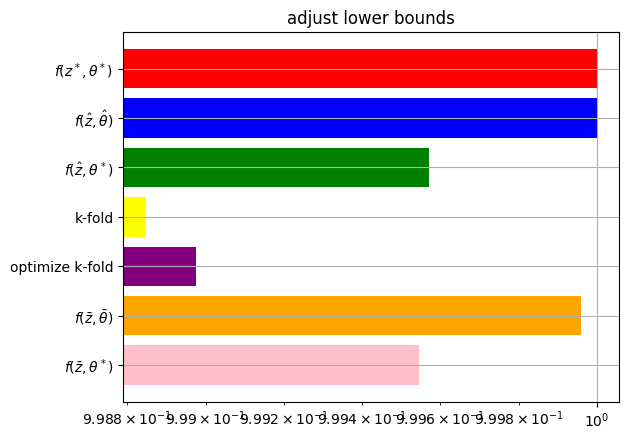

In [75]:
# so_salse po_salse t_salse cvとlbがついている要素を横棒グラフでplot
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
    r"optimize k-fold",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
values = [so_salse, po_salse, t_salse, cv, lb_bo, lb_po, t_lb_salse]
# 色を指定
colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.barh(labels, values, color=colors)
# plt.bar(labels, values, color=colors)
# 順番を逆にする
plt.gca().invert_yaxis()

# log
plt.xscale("log")
# グリッドを表示
plt.grid(True)

plt.title("adjust lower bounds")
plt.show()


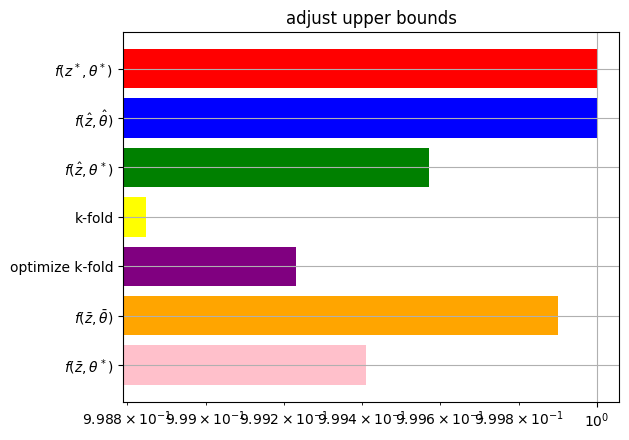

In [76]:
# so_salse po_salse t_salse cvとubがついている要素を棒グラフでplot
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
    r"optimize k-fold",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
values = [so_salse, po_salse, t_salse, cv, ub_bo, ub_po, t_ub_salse]
# 色を指定
colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.barh(labels, values, color=colors)
# 順番を逆にする
plt.gca().invert_yaxis()

# log
plt.xscale("log")
# グリッドを表示
plt.grid(True)
plt.title("adjust upper bounds")
plt.show()


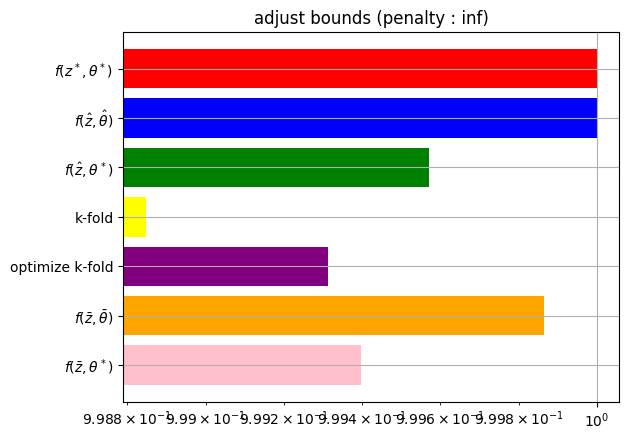

In [77]:
# so_salse po_salse t_salse cvとinfがついている要素を棒グラフでplot
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
    r"optimize k-fold",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
values = [so_salse, po_salse, t_salse, cv, inf_bo, inf_po, t_inf_salse]
# 色を指定
colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.barh(labels, values, color=colors)
# 順番を逆にする

plt.gca().invert_yaxis()

# log
plt.xscale("log")
# グリッドを表示
plt.grid(True)
plt.title("adjust bounds (penalty : inf)")
plt.show()


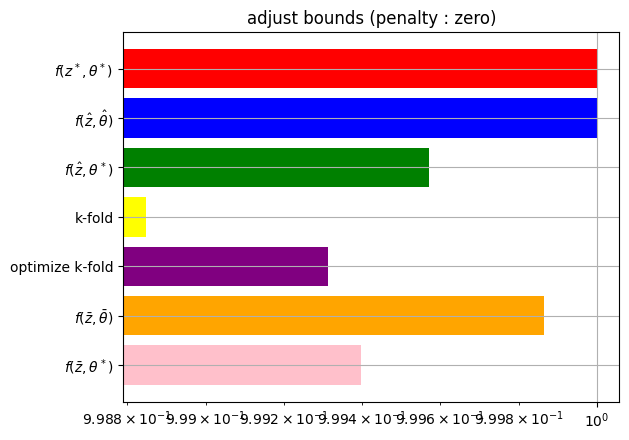

In [78]:
# so_salse po_salse t_salse cvとzeroがついている要素を棒グラフでplot
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
    r"optimize k-fold",
    r"$f(\bar{z},\bar\theta)$",
    r"$f(\bar{z},\theta^*)$",
]
values = [so_salse, po_salse, t_salse, cv, zero_bo, zero_po, t_zero_salse]
# 色を指定

colors = ["red", "blue", "green", "yellow", "purple", "orange", "pink"]

plt.barh(labels, values, color=colors)
# 順番を逆にする

plt.gca().invert_yaxis()

# log
plt.xscale("log")
# グリッドを表示
plt.grid(True)
plt.title("adjust bounds (penalty : zero)")
plt.show()


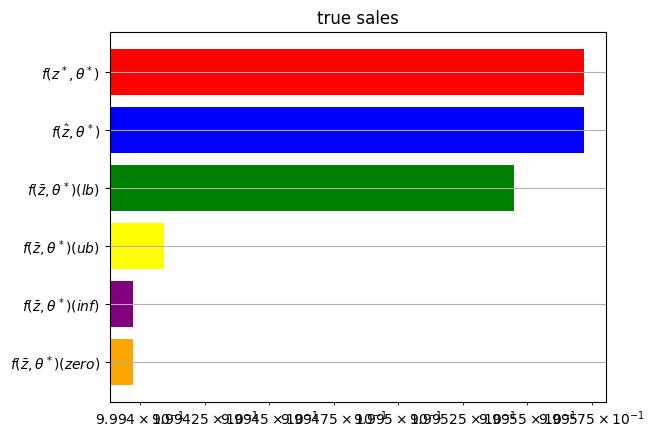

In [79]:
# so_salseそれぞれのt_..._salseをplot(t_salse, t_lb_salse, t_ub_salse, t_inf_salse, t_zero_salse)
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\theta^*)$",
    r"$f(\bar{z},\theta^*)(lb)$",
    r"$f(\bar{z},\theta^*)(ub)$",
    r"$f(\bar{z},\theta^*)(inf)$",
    r"$f(\bar{z},\theta^*)(zero)$",
]
values = [t_salse, t_salse, t_lb_salse, t_ub_salse, t_inf_salse, t_zero_salse]
# 色を指定
colors = ["red", "blue", "green", "yellow", "purple", "orange"]

plt.barh(labels, values, color=colors)
# 順番を逆にする
plt.gca().invert_yaxis()

# log

plt.xscale("log")
# グリッドを表示
plt.grid(True)
plt.title("true sales")
plt.show()


In [ ]:
# 上記の結果をまとめた表を作成



# データを作成

data = {
    "method": [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
        r"optimize k-fold",
        r"$f(\bar{z},\bar\theta)$",
        r"$f(\bar{z},\theta^*)$",
    ],
    "adjust lower bounds": [so_salse, po_salse, t_salse, cv, lb_bo, lb_po, t_lb_salse],
    "adjust upper bounds": [so_salse, po_salse, t_salse, cv, ub_bo, ub_po, t_ub_salse],
    "adjust bounds (penalty : inf)": [
        so_salse,
        po_salse,
        t_salse,
        cv,
        inf_bo,
        inf_po,
        t_inf_salse,
    ],
    "adjust bounds (penalty : zero)": [
        so_salse,
        po_salse,
        t_salse,
        cv,
        zero_bo,
        zero_po,
        t_zero_salse,
    ],
}

df = pd.DataFrame(data)
df


,method,adjust lower bounds,adjust upper bounds,adjust bounds (penalty : inf),adjust bounds (penalty : zero)
0,"$f(z^*,\theta^*)$",1.000000,1.000000,1.000000,1.000000
1,"$f(\hat{z},\hat\theta)$",1.000000,1.000000,1.000000,1.000000
2,"$f(\hat{z},\theta^*)$",0.999572,0.999572,0.999572,0.999572
3,k-fold,0.998848,0.998848,0.998848,0.998848
4,optimize k-fold,0.998975,0.999230,0.999314,0.999314
5,"$f(\bar{z},\bar\theta)$",0.999961,0.999901,0.999866,0.999866
6,"$f(\bar{z},\theta^*)$",0.999545,0.999409,0.999397,0.999397


In [81]:
df.to_csv("result.csv")

In [88]:
# 次の減少率を計算(po_salse_listからt_salse_list,lb_po_listからt_lb_salse_list, ub_po_listからt_ub_salse_list, inf_po_listからt_inf_salse_list, zero_po_listからt_zero_salse_list)
# df形式に変換してcsvファイルに保存
po_salse_list_np = np.array(po_salse_list)
t_salse_list_np = np.array(t_salse_list)
lb_po_list_np = np.array(lb_po_list)
t_lb_salse_list_np = np.array(t_lb_salse_list)
ub_po_list_np = np.array(ub_po_list)
t_ub_salse_list_np = np.array(t_ub_salse_list)
inf_po_list_np = np.array(inf_po_list)
t_inf_salse_list_np = np.array(t_inf_salse_list)
zero_po_list_np = np.array(zero_po_list)
t_zero_salse_list_np = np.array(t_zero_salse_list)

po_salse_list_np = (po_salse_list_np - t_salse_list_np) / po_salse_list_np
lb_po_list_np = (lb_po_list_np - t_lb_salse_list_np) / lb_po_list_np
ub_po_list_np = (ub_po_list_np - t_ub_salse_list_np) / ub_po_list_np
inf_po_list_np = (inf_po_list_np - t_inf_salse_list_np) / inf_po_list_np
zero_po_list_np = (zero_po_list_np - t_zero_salse_list_np) / zero_po_list_np

# 平均を計算
po_salse_list_np = np.mean(po_salse_list_np)
lb_po_list_np = np.mean(lb_po_list_np)
ub_po_list_np = np.mean(ub_po_list_np)
inf_po_list_np = np.mean(inf_po_list_np)
zero_po_list_np = np.mean(zero_po_list_np)

data = {
    "method": [
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\bar{z},\theta^*)(lb)$",
        r"$f(\bar{z},\theta^*)(ub)$",
        r"$f(\bar{z},\theta^*)(inf)$",
        r"$f(\bar{z},\theta^*)(zero)$",
    ],
    "decrease rate": [
        np.mean(po_salse_list_np),
        np.mean(lb_po_list_np),
        np.mean(ub_po_list_np),
        np.mean(inf_po_list_np),
        np.mean(zero_po_list_np),
    ],
}

df_new = pd.DataFrame(data)
df_new

df_new.to_csv("decrease_rate.csv")


In [89]:
df_new

,method,decrease rate
0,"$f(\hat{z},\hat\theta)$",0.000428
1,"$f(\bar{z},\theta^*)(lb)$",0.000416
2,"$f(\bar{z},\theta^*)(ub)$",0.000491
3,"$f(\bar{z},\theta^*)(inf)$",0.000469
4,"$f(\bar{z},\theta^*)(zero)$",0.000469


In [ ]:
# 箱ひげ図の作成
data = [inf_time_list, zero_time_list]
plt.boxplot(data, labels=['inf_time_list', 'zero_time_list'])
plt.ylabel('time')

plt.show()

In [ ]:
# 最大値、最小値、平均値の取得
統計データ = {
    'リスト名': ['inf_time_list', 'zero_time_list'],
    '最大値': [max(inf_time_list), max(zero_time_list)],
    '最小値': [min(inf_time_list), min(zero_time_list)],
    '平均値': [
        sum(inf_time_list) / len(inf_time_list),
        sum(zero_time_list) / len(zero_time_list)
    ]
}

# DataFrameに変換
df = pd.DataFrame(統計データ)

# CSVファイルに出力
df.to_csv('統計データ.csv', index=False, encoding='utf-8-sig')